# Analysis of MQTT Input Data

In [1]:
recording_file = "2020-06-02T10-31-46"
load_until_seconds = 8000

In [2]:
import boto3
import re
import base64
import json
from datetime import datetime, timedelta
from dateutil.parser import isoparse
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from ptinsight.common.plotting import plot_init, plot_format, plot_save, add_relative_time

plot_init()

In [3]:
def load_timestamps():
    csv_writer = csv.writer(open(
        f"results/{recording_file}.csv",
        "w",
        encoding="utf-8",
        newline="",
        buffering=1,
    ))
    csv_writer.writerow(("event_type", "ingestion_timestamp", "event_timestamp"))

    s3_file = boto3.resource("s3").Object("mqtt-recordings", f"mqtt.hsl.fi/{recording_file}.rec")

    body = s3_file.get()["Body"]
    lines = map(lambda l: l.decode(), body.iter_lines())

    original_broker = next(lines)[8:]
    original_topics = next(lines)[8:]
    original_t_start = isoparse(next(lines)[12:]).replace(
        microsecond=0
    )
    next(lines)

    print(f"Recorded from {original_broker} at {str(original_t_start)}")
    print(f"Topics: {original_topics}\n")

    message_regex = re.compile(r'(\S+) "(.+)" (\d) (\d) (\S*)')

    for i, line in enumerate(lines):
        t_offset, topic, _, _, payload = message_regex.match(line).groups()
        t_offset = float(t_offset)
        payload = json.loads(base64.b64decode(payload))

        event_type = list(payload.keys())[0]
        if not event_type in ["VP", "ARS", "DEP"]:
            continue
            
        if i%5000 == 0:
            print(f"{i=} {t_offset}")

        if t_offset >= load_until_seconds:
            break

        ingestion_timestamp = original_t_start + timedelta(seconds=t_offset)
        event_timestamp = isoparse(payload[event_type]["tst"])
        csv_writer.writerow((event_type.lower(), ingestion_timestamp.isoformat(), event_timestamp.isoformat()))

In [4]:
# Takes a long time! Only use for new recordings
# load_timestamps()

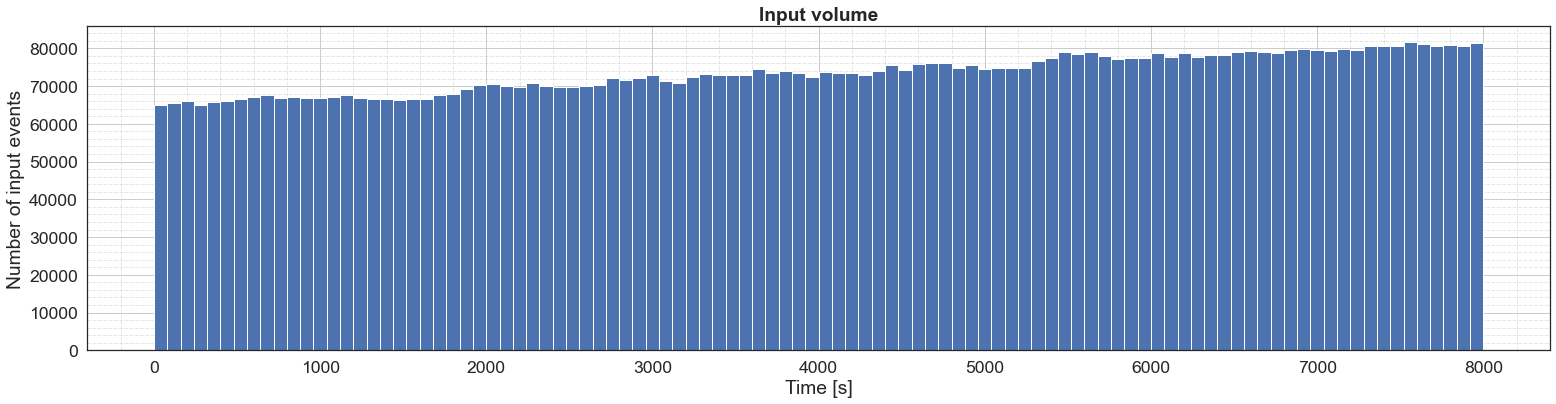

In [5]:
def plot_timestamps():
    data = pd.read_csv(f"results/{recording_file}.csv", parse_dates=["ingestion_timestamp", "event_timestamp"])
    data["ingestion_delay"] = data["ingestion_timestamp"] - data["event_timestamp"]
    add_relative_time(data, "ingestion_timestamp")
    
    plt.figure(figsize=[22, 6])
    plt.hist(data["t"], bins=100)
    plt.xlabel("Time [s]")
    plt.ylabel("Number of input events")
    plt.title("Input volume")
    
    plot_format()
    plot_save(f"ingestion_timestamp")
    
plot_timestamps()